In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow import keras
import sys
sys.path.append('../scripts')
import train

In [2]:
# Load data, model, and make predictions

MODEL_PATH = '../models/2023.01.30-11/'
METADATA_PATH = '../metadata/ecg_metadata_2023jan16_final.csv'
ECG_SOURCE_DIR = '../ecgs/csv_normalized_2500/'

(_, x_intval, x_extval, _, y_intval_true, y_extval_true) = train._import_data(
    metadata_path=METADATA_PATH,
    ecg_source_dir=ECG_SOURCE_DIR)

model = train._load_model(MODEL_PATH)

y_intval_pred = model.predict(x_intval)
y_extval_pred = model.predict(x_extval)



Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-02 16:34:20.763235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 16:34:20.763836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-02 16:34:22.603104: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 16:34:22.699272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 66ms/step


Sen 0.98, Spe 0.31, PPV 0.75, NPV 0.89
Sen 0.87, Spe 0.96, PPV 0.98, NPV 0.78
Sen 0.98, Spe 0.30, PPV 0.80, NPV 0.82
Sen 0.88, Spe 0.85, PPV 0.94, NPV 0.71


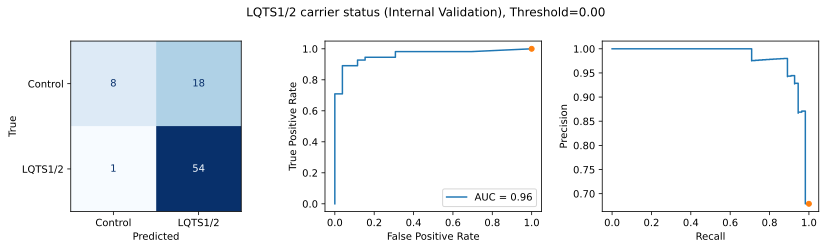

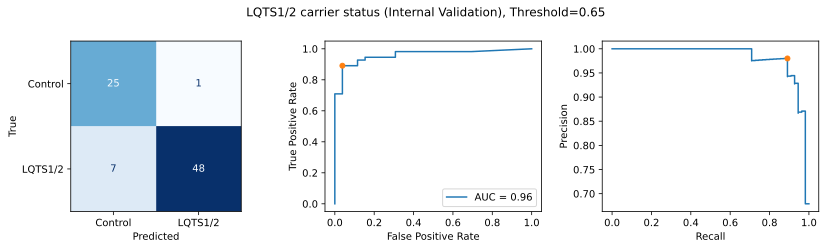

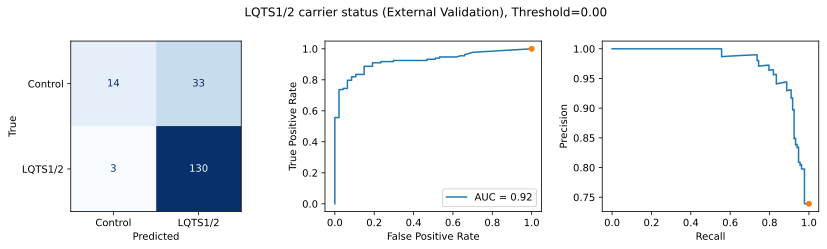

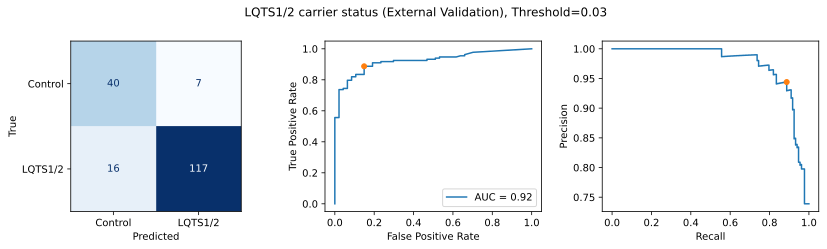

In [3]:
def roc_pr_curves(y_true, y_probas, thresh, title, labels):
    y_thresh = np.where(y_probas>thresh, 1, 0)

    fig, ax = plt.subplots(1,3,figsize=(12,3.5))
    plt.tight_layout(pad=3)
    fig.suptitle(title, y=1)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_thresh)
    print(f"Sen {cm[1][1]/(cm[1][0]+cm[1][1]):.2f}, Spe {cm[0][0]/(cm[0][0]+cm[0][1]):.2f}, PPV {cm[1][1]/(cm[1][1]+cm[0][1]):.2f}, NPV {cm[0][0]/(cm[0][0]+cm[1][0]):.2f}")
    cm_disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels,
    )
    cm_disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")

    # ROC curve
    fpr, tpr, roc_thresholds = metrics.roc_curve(y_true, y_probas)
    auc = metrics.roc_auc_score(y_true, y_probas)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
    display.plot(ax=ax[1])
    ix = np.where(roc_thresholds>=thresh)[0][-1]
    # ax[1].text(fpr[ix]+0.02,tpr[ix]-0.08, f"Sen {tpr[ix]:.2f}\nSpe {1-fpr[ix]:.2f}")
    ax[1].plot(fpr[ix],tpr[ix], marker='.', markersize=10)

    # PR curve
    precision, recall, pr_thresholds = metrics.precision_recall_curve(y_true, y_probas)
    metrics.PrecisionRecallDisplay.from_predictions(
        y_true, y_probas, ax=ax[2])
    ax[2].set_ylabel("Precision")
    ax[2].set_xlabel("Recall")
    ax[2].get_legend().remove()
    ix = np.where(pr_thresholds<=thresh)[0][-1]
    ax[2].plot(recall[ix],precision[ix], marker='.', markersize=10)

def youden_thresh(y_true, y_probas):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas)
    J = tpr - fpr
    ix = np.argmax(J)
    return(thresholds[ix])

def best_spe_thresh(y_true, y_probas):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas)
    ix = len(fpr)-np.argmax(np.flip(1-fpr))-1
    return(thresholds[ix])

def best_sen_thresh(y_true, y_probas):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_probas)
    ix = np.argmax(tpr)
    return(thresholds[ix])

# Internal Validation
# True = LQTS1/2
# False = Control
y_true = np.where(y_intval_true[:,0]==0,1,0)
y_probas = 1-y_intval_pred[:,0]

t = best_sen_thresh(y_true, y_probas)
roc_pr_curves(
    y_true, y_probas,
    thresh=t,
    title=f"LQTS1/2 carrier status (Internal Validation), Threshold={t:.2f}",
    labels=['Control', 'LQTS1/2'],
)

t = youden_thresh(y_true, y_probas)
roc_pr_curves(
    y_true, y_probas,
    thresh=t,
    title=f"LQTS1/2 carrier status (Internal Validation), Threshold={t:.2f}",
    labels=['Control', 'LQTS1/2'],
)

# # External Validation
y_true = np.where(y_extval_true[:,0]==0,1,0)
y_probas = 1-y_extval_pred[:,0]

t = best_sen_thresh(y_true, y_probas)
roc_pr_curves(
    y_true, y_probas,
    thresh=t,
    title=f"LQTS1/2 carrier status (External Validation), Threshold={t:.2f}",
    labels=['Control', 'LQTS1/2'],
)

t = youden_thresh(y_true, y_probas)
roc_pr_curves(
    y_true, y_probas,
    thresh=t,
    title=f"LQTS1/2 carrier status (External Validation), Threshold={t:.2f}",
    labels=['Control', 'LQTS1/2'],
)


Sen 0.73, Spe 1.00, PPV 1.00, NPV 0.45
Sen 0.78, Spe 0.91, PPV 0.95, NPV 0.67


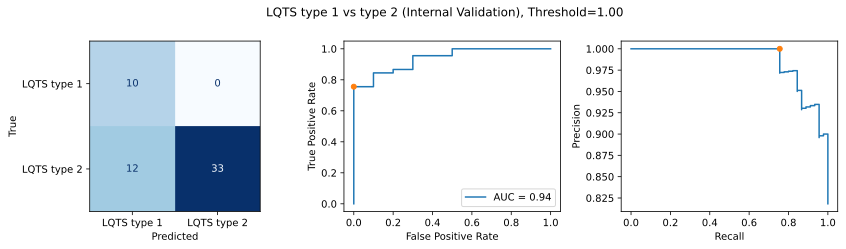

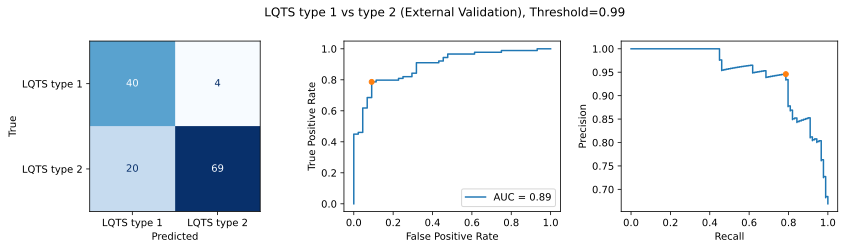

In [4]:
def lqt1_probas(y_true, y_probas):
    # Select where true label is not 'Control'
    ix = np.where(y_true[:,0]!=1)
    # y_true is label for whether ECG is 'LQTS1'
    y_true = y_true[ix, 1].flatten()
    # y_probas is probability for 'LQTS1'
    # if there is a case where the model guessed [0.33, 0.33, 0.33] (unsure if control/type 1/type 2)
    # and the true genotype was type 1, instead of saying the probability of type 1 is 0.33, really it 
    # should be 0.5 (50/50% guess)
    y_probas = np.apply_along_axis(lambda a: a[0]/(a[0]+a[1]), 1, y_probas[ix,1:3][0])

    return y_true, y_probas

# LQTS1 vs LQTS2, Internal Validation
y_true, y_probas = lqt1_probas(y_intval_true, y_intval_pred)
t = youden_thresh(y_true, y_probas)
roc_pr_curves(
    y_true, y_probas,
    thresh=t,
    title=f"LQTS type 1 vs type 2 (Internal Validation), Threshold={t:.2f}",
    labels=['LQTS type 1', 'LQTS type 2'],
)

# LQTS1 vs LQTS2, External Validation
y_true, y_probas = lqt1_probas(y_extval_true, y_extval_pred)
t = youden_thresh(y_true, y_probas)
roc_pr_curves(
    y_true, y_probas,
    thresh=t,
    title=f"LQTS type 1 vs type 2 (External Validation), Threshold={t:.2f}",
    labels=['LQTS type 1', 'LQTS type 2'],
)